# Image Preprocessing Experimentation

This notebook documents the experimentation with various image preprocessing steps. The algorithms should work with dicom images with both `PresentationIntentType` equal to `FOR PROCESSING` and  to `FOR PRESENTATION`, with any kind of `PresentationLUTShape`, and `PhotometricInterpretation`.

**It builds on scrips from:**
- https://github.com/GKalliatakis/MammoAI
- https://github.com/CleonWong/Can-You-Find-The-Tumour
- https://github.com/brentnall


The general steps taken in this notebook are as follows:
- Understanding the images
- Removing artefacts
- Resize
- Orientate
- Pad

**IMAGE PREPROCESSING PIPELINE AFTER EXPERIMENTATION:**

- If `image view == CC`:
    1. Crop --> `CropBorders()`
    3. Remove artefacts --> `OwnGlobalBinarise()`, `OpenMask()`, `SortContoursByArea()`, `XLargestBlobs()`, `ApplyMask()`
    4. Horizontal-flip --> `HorizontalFlip()` (not necessary)
    5. Pad --> `Pad()` (not necessary)
    6. Resize

   <br>

- If `image view == MLO`:
    1. Crop
    3. Remove artefacts
    4. Horizontal flip (not necessary)
    5. Remove pectoral muscle (TO DO)
    6. Pad (not necessary)
    7. Resize


### Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import cv2
import pydicom
import os
import skimage

from pathlib             import Path


from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_windowing, apply_voi_lut, apply_voi
import numpy.ma as ma
from scipy.stats.mstats import mquantiles
from skimage.transform import rescale
from skimage.filters import threshold_otsu
from skimage import exposure

from PIL import Image



### Helper functions

In [2]:
def ShowHist255(img, ignore_zero = False):
    hist, bin_edges = np.histogram(img, bins=255, density=False)
    
    if ignore_zero:
        plt.plot(bin_edges[1:-1], hist[1:])
    else:
        plt.plot(bin_edges[0:-1], hist)
        
    plt.show()

In [3]:
def img_original_raw_or_not(fn_or_dicom):
    # Corrects the encoding (MONOCHROME) and applies the rescale slope and intercept if tags are present
    # Using new functions from pydicom library
    # Separate processing if image is 'FOR PRESENTATION' or 'FOR PRESENTATION'
    # Remark: The functions `apply_modality_lut`, `apply_voi` and `apply_windowing` 
    # return the numpy array unchanged on raw DICOMS 
    # because the tags required by these functions are missing.

    if isinstance(fn_or_dicom, str):
        dicom = pydicom.read_file(fn_or_dicom)
    elif isinstance(fn_or_dicom, pydicom.dataset.FileDataset):
        dicom = fn_or_dicom
    else:
        raise Exception(
            'fn_or_dicom is not a file name or dicom object. Type(fn_or_dicom)={}'.format(type(fn_or_dicom)))
    
    img = apply_modality_lut(dicom.pixel_array, dicom).astype(int)
    
    if dicom.PresentationIntentType == 'FOR PRESENTATION':

        inverse_pls = False
        if 'PresentationLUTShape' in dicom:
            if dicom.PresentationLUTShape == 'INVERSE':
                img = apply_windowing(img, dicom).astype(int)
                inverse_pls = True

        if inverse_pls:
            
            img = apply_voi(img, dicom)  ## no lut
        else:
            img = apply_voi_lut(img, dicom)

        if 'PhotometricInterpretation' in dicom:
            if dicom.PhotometricInterpretation == 'MONOCHROME1':
                img = img.max() - img
                
        
    elif dicom.PresentationIntentType == 'FOR PROCESSING':

        inverse_pls = False
        if 'PresentationLUTShape' in dicom:
            if dicom.PresentationLUTShape == 'INVERSE':
                # (0028,1050) Window Center and (0028,1051) Window Width not present
                # so leaves the array unchanged
                img = apply_windowing(img, dicom).astype(int)
                inverse_pls = True
                
        # VOI LUT attribute required only if Presentation Intent Type (0008,0068) is FOR PRESENTATION
        # ...so here leaves the array unchanged
        if inverse_pls:
            img = apply_voi(img, dicom)  ## no lut
        else:
            img = apply_voi_lut(img, dicom)
        
        # this is the only bit that does something in 'FOR PROCESSING'
        if 'PhotometricInterpretation' in dicom:
            if dicom.PhotometricInterpretation == 'MONOCHROME1':
                img = img.max() - img
        
    # Some images have 3 channels (error images):
    if img.ndim > 2:
        print('WARNING: Image with more than 1 channel. Applying rgb2gray transformation')
        # img = imgu.rgb2gray(img)


    # print("This image is " + str(dicom.PresentationIntentType) + "; Presentation LUT shape " + str(dicom.PresentationLUTShape) + "; and Photometric Interpretation " + str(dicom.PhotometricInterpretation))
    return img.astype(int)

### Read the selected .dcm files

In [4]:
# Working directories
OMI_DB_directory = "/home/celeste/data8/optimam/main/image_db/sharing/omi-db/images/" # here we have one directory per patient, each with a subdirectory for each study

under_55_dir = '/home/celeste/Projects/TDA_breast_density/Data/images/normal_under55/'
if not os.path.exists(under_55_dir):
    os.makedirs(under_55_dir)
    
between_55_to_65_dir = '/home/celeste/Projects/TDA_breast_density/Data/images/normal_55_to_65/'
if not os.path.exists(between_55_to_65_dir):
    os.makedirs(between_55_to_65_dir)

over_65_dir = '/home/celeste/Projects/TDA_breast_density/Data/images/normal_over65/'
if not os.path.exists(over_65_dir):
    os.makedirs(over_65_dir)

In [5]:
normal_under55 =  pd.read_csv('~/Projects/TDA_breast_density/Data/lookup/normal_under55.csv')
normal_55_to_65 = pd.read_csv('~/Projects/TDA_breast_density/Data/lookup/normal_55_to_65.csv')
normal_over65 = pd.read_csv('~/Projects/TDA_breast_density/Data/lookup/normal_over65.csv')

In [6]:
# making the three lists of dicoms belonging to the selected dataset
list_paths_under_55 = OMI_DB_directory + normal_under55['ClientID'].astype(str) +  '/' + normal_under55['StudyInstanceUID'].astype(str)+ '/' + normal_under55['SOPInstanceUID'].astype(str) + '.dcm'
list_paths_55_to_65 = OMI_DB_directory + normal_55_to_65['ClientID'].astype(str) +  '/' + normal_55_to_65['StudyInstanceUID'].astype(str)+ '/' + normal_55_to_65['SOPInstanceUID'].astype(str) + '.dcm'
list_paths_over_65 = OMI_DB_directory + normal_over65['ClientID'].astype(str) +  '/' + normal_over65['StudyInstanceUID'].astype(str)+ '/' + normal_over65['SOPInstanceUID'].astype(str) + '.dcm'


In [7]:
# Paths of selected .dcm files
selected_paths = list_paths_under_55[:4]

ds = [pydicom.dcmread(selected_paths[i]) for i in range(len(selected_paths))]

arr = [_ds.pixel_array for _ds in ds]

### Visualise the original images

Remark that this doesn't correct the encoding, and raw ('FOR PROCESSING') images will either appear as black blobs on white background, or as white blobs on black background. Still we look at them to know what we are originally working with and understand the data. 

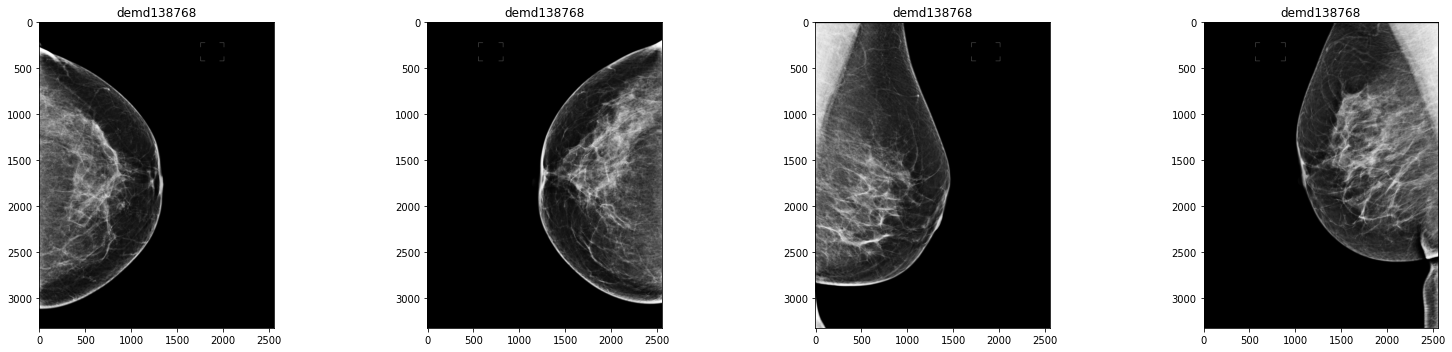

In [8]:
# Plot together
fig, ax = plt.subplots(nrows=1, ncols=len(selected_paths), figsize = (22, 5))

for i in range(len(selected_paths)):
    ax[i].imshow(arr[i], cmap="gray")
    ax[i].set_title(f"{ds[i].PatientID}")
    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/original.png", dpi=300)

In [9]:
# We use the helper function to be able to plot any presentation type and encoding correctly.

arr_correctly_read = [img_original_raw_or_not(a) for a in selected_paths]

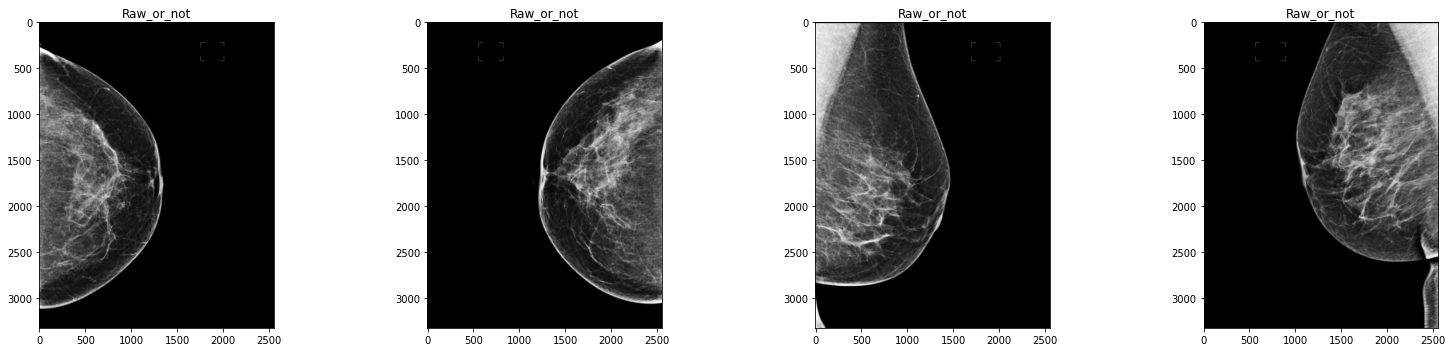

In [10]:
# Plot together
fig, ax = plt.subplots(nrows=1, ncols=len(selected_paths), figsize = (22, 5))

# Plot correctly read
for i in range(len(selected_paths)):
    ax[i].imshow(arr_correctly_read[i], cmap="gray")
    ax[i].set_title("Raw_or_not")

plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/correctly_read.png", dpi=300)

---

## Understanding the images

### 1. Shape, dtype, range of values


- **Observations:**
    1. Images are not in standard sizes.
    2. `pydicom.pixel_array` method outputs the images in Numpy arrays that have `dtype = uint16`.

In [11]:
for a in arr:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (3328, 2560)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 4095)
---
Shape: (3328, 2560)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 4095)
---
Shape: (3328, 2560)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 4095)
---
Shape: (3328, 2560)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 4095)
---


### 2. Normalise (or not)

- **Observations:**
    1. Doing min-max normalisation changes the intensities in the image (i.e. **the image is DISTORTED**)
        - [Image datatypes and what they mean](https://scikit-image.org/docs/dev/user_guide/data_types.html)
    
- **Conclusions:**
    1. Don't need to normalise for image preprocessing. Only normalise to \[0, 1\] after image preprocessing (before feeding into model).

Still we give here the tool (by default normalises between 0 and 255 but the arguments can be changed. An example can be plotted to compare with the original images.

In [12]:
def img_norm_raw(fn_or_dicom, ymin=0, ymax=255):
    # For presentation: normalizes the image to the range [ymin,ymax])
    # For processing: removes background, windows, normalizes the image to the range [ymin,ymax]
    # Returns: a list (numpy array, string)
    # where the string is the filename to save it


    if isinstance(fn_or_dicom, str):
        dicom = pydicom.read_file(fn_or_dicom)
    elif isinstance(fn_or_dicom, pydicom.dataset.FileDataset):
        dicom = fn_or_dicom
    else:
        raise Exception(
            'fn_or_dicom is not a file name or dicom object. Type(fn_or_dicom)={}'.format(type(fn_or_dicom)))
    
    img = img_original_raw_or_not(dicom)
        
    # Checking if the image is 'FOR PROCESSING' or 'FOR PRESENTATION'
    if (dicom.PresentationIntentType=='FOR PRESENTATION'):

        imgNorm = cv2.normalize(img, None, ymin, ymax, cv2.NORM_MINMAX) 
  
        return imgNorm.astype('float32')


    
    elif (dicom.PresentationIntentType=='FOR PROCESSING'):
        
        
        img255 = (255*(img/float(np.max(img)))).astype('uint8')  


        #removing the background - thresholding
        ret,th = cv2.threshold(img255,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binary = 1*(img255<ret)
        imgm = ma.masked_array(img, mask=binary) #apply mask
        #img1 = ma.masked_array(np.maximum(np.ones_like(imgm), imgm)), mask=binary) #log transform

        ## windowing quantiles
        myquants=mquantiles(imgm.compressed(), [0,0.1,0.25,0.5,0.75,0.85,1]).tolist()
    
        ## windowing
        mymin=np.ones_like(imgm) * (myquants[2]) ##don't window white
        #myzero=np.zeros_like(imgm)
        
        img2 = ma.masked_array(np.maximum(mymin, img)- myquants[2] , mask=binary) ##don't window white
        
        ## fill the white 
        imgb = img2.filled(np.min(img))
        imgb = imgb.astype('float32')
        
        ### Normalisation 
        imgNorm = cv2.normalize(imgb, None, ymin, ymax, cv2.NORM_MINMAX) 

        ### Name that we will use to save it
        filename = dicom.PatientID + dicom.ViewPosition + dicom.ImageLaterality + dicom.AcquisitionDate

        return imgNorm.astype('float32')
    
    else:
        raise Exception(
        'This dicom is neither FOR PRESENTATION nor FOR PROCESSING')






In [13]:
arr_norm = [img_norm_raw(a) for a in selected_paths]


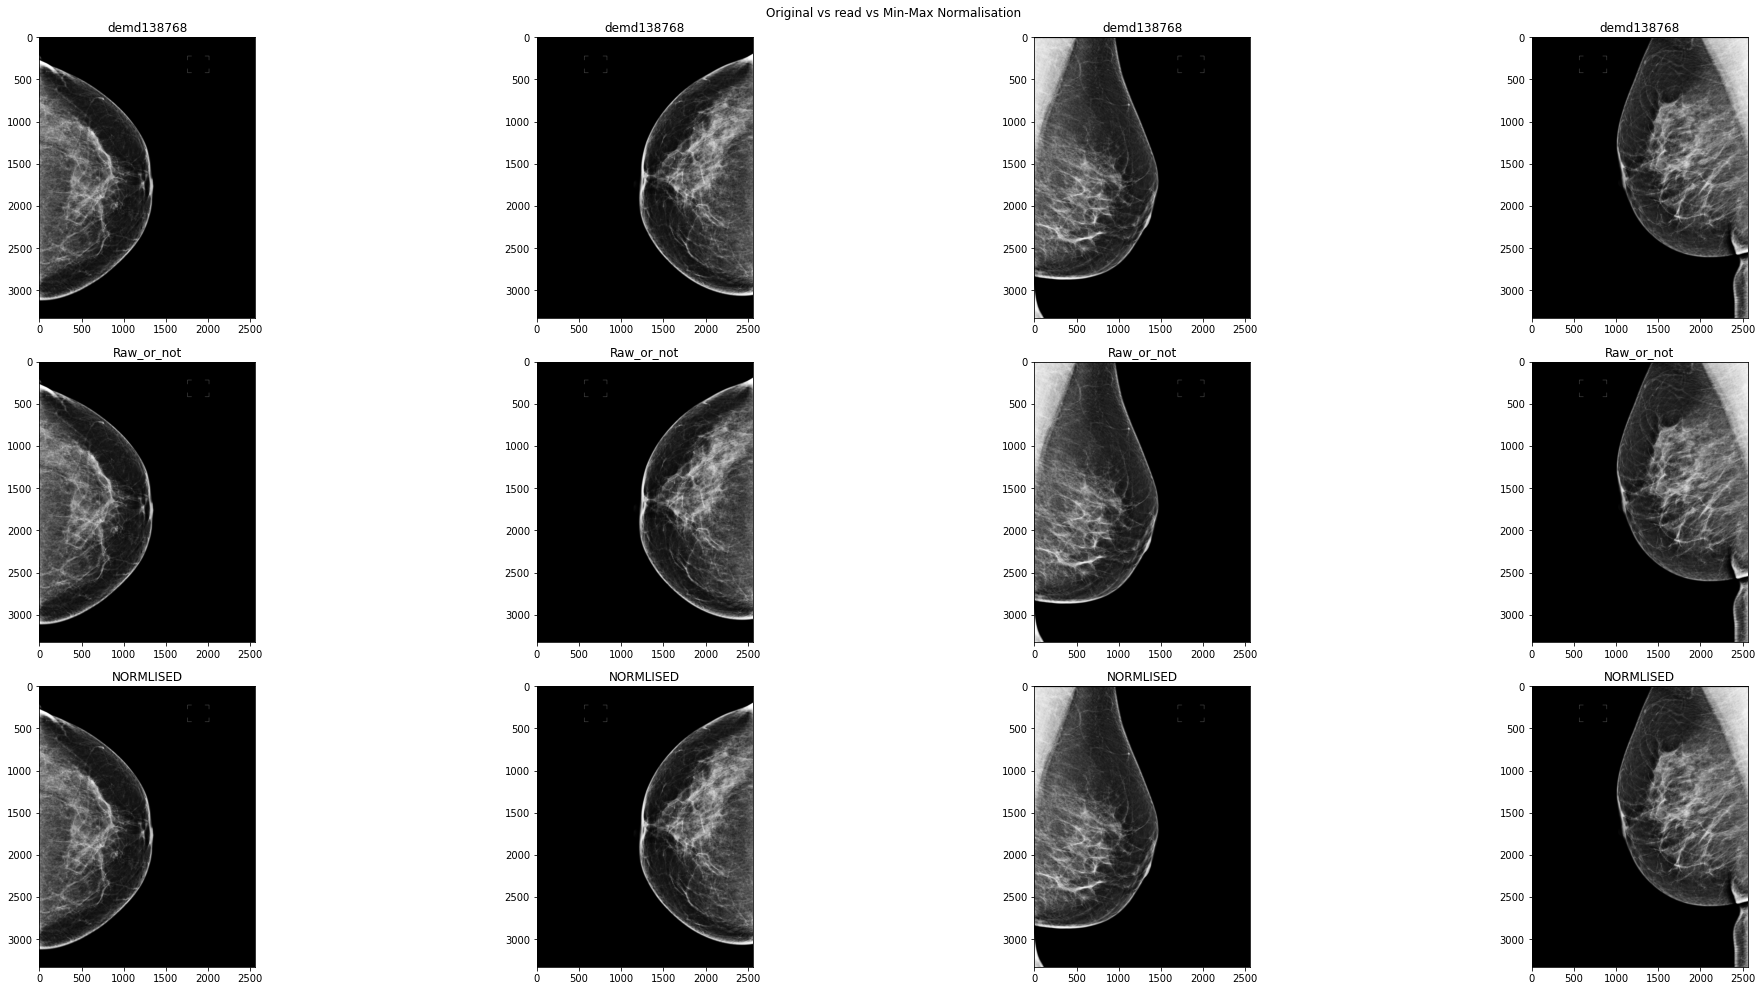

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=len(selected_paths), figsize = (30, 14))

fig.suptitle("Original vs read vs Min-Max Normalisation")

# Plot original
for i in range(len(selected_paths)):
    ax[0][i].imshow(arr[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")

# Plot correctly read
for i in range(len(selected_paths)):
    ax[1][i].imshow(arr_correctly_read[i], cmap="gray")
    ax[1][i].set_title("Raw_or_not")
    
# Plot normalised
for i in range(len(selected_paths)):
    ax[2][i].imshow(arr_norm[i], cmap="gray")
    ax[2][i].set_title("NORMLISED")
    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/normalised.png", dpi=300)

In [15]:
for a in arr:
    print(a.dtype)
    print({a.min(), a.max()})

for a in arr_correctly_read:
    print(a.dtype)
    print({a.min(), a.max()})

for a in arr_norm:
    print(a.dtype)
    print({a.min(), a.max()})

uint16
{0, 4095}
uint16
{0, 4095}
uint16
{0, 4095}
uint16
{0, 4095}
int64
{0, 4095}
int64
{0, 4095}
int64
{0, 4095}
int64
{0, 4095}
float32
{0.0, 255.0}
float32
{0.0, 255.0}
float32
{0.0, 255.0}
float32
{0.0, 255.0}


### 3. uint16 (16-bit) -> uint8 (8-bit)

- **Why:**
    1. We have to change from 16-bit to 8-bit because `cv2.threshold` and `cv2.adaptiveThreshold()` requires 8-bit image array.
    
<br>

- **Observations:**
    1. `skimage.img_as_ubyte()` does not seem to change the relative intensities within each image as drastically as min-max normalisation.
    2. BUT converting from `uint16` to `uint8` removes the granularity of the information in an image.

<br>

- **Conclusions:**
    1. we couldn't make `skimage.img_as_ubyte()` work, but we rescaled the images by hand rather than just doing astype('uint8'). This could be fixed better.

In [16]:
#arr_uint8 = [skimage.img_as_ubyte(a) for a in arr_correctly_read]

arr_uint8 = [(255*(a/float(np.max(a)))).astype('uint8') for a in arr_correctly_read]

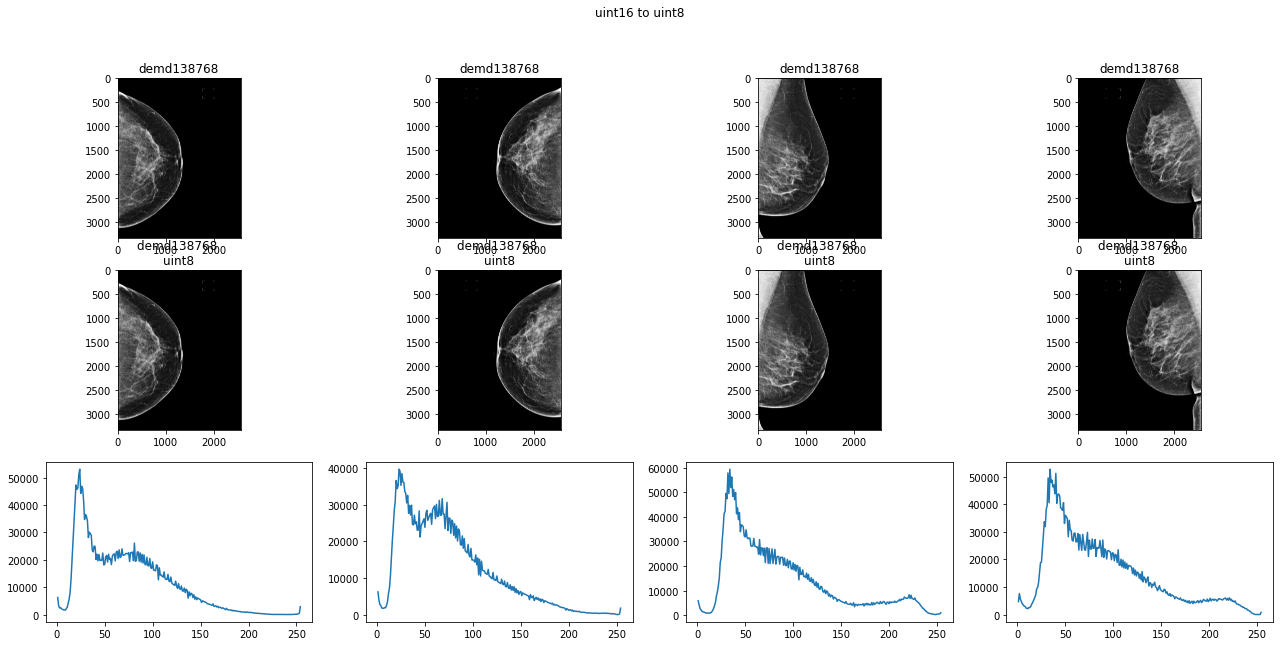

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=len(selected_paths), figsize = (22, 10))

fig.suptitle("uint16 to uint8")

# Plot original uint16
for i in range(len(selected_paths)):
    ax[0][i].imshow(arr_correctly_read[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
# Plot uint8
for i in range(len(selected_paths)):
    ax[1][i].imshow(arr_uint8[i], cmap="gray")
    ax[1][i].set_title(f"{ds[i].PatientID} \nuint8")
    
# Plot histogram of uint8 (ignoring 0)
for i in range(len(selected_paths)):
    hist, bin_edges = np.histogram(arr_uint8[i], bins=255, density=False)
    ax[2][i].plot(bin_edges[1:-1], hist[1:])
    
# plt.tight_layout()
# plt.savefig(fname="../outputs/image-preprocessing/uint8.png", dpi=300)

In [50]:
for a in arr:
    print(a.dtype)
    print(a.min(), a.max())

for a in arr_uint8:
    print(a.dtype)
    print(a.min(), a.max())

uint16
0 4095
uint16
0 4095
uint16
0 4095
uint16
0 4095
uint8
0 255
uint8
0 255
uint8
0 255
uint8
0 255


---

## Initial crop around the image boundaries

- **Why:**
    - Some scans have a white border on some/all sides of the frame. Taking away a small percentage of the image on all sides might remove this border while not removing too much of the image such that we lose valuable information.

- **However:**
    - For OPTIMAM images this shouldn't be necessary. We'll just keep it in the toolbox. 

In [18]:
def CropBorders(img):
    
    '''
    This function crops 1% from all four sides of the given
    image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to crop.
        
    Returns
    -------
    cropped_img: {numpy.ndarray}
        The cropped image.
    '''
    nrows, ncols = img.shape

    # Get the start and end rows and columns
    l_crop = int(ncols * 0.01)
    r_crop = int(ncols * (1 - 0.04))
    u_crop = int(nrows * 0.01)
    d_crop = int(nrows * (1 - 0.04))

    cropped_img = img[u_crop:d_crop, l_crop:r_crop]
    
    return cropped_img

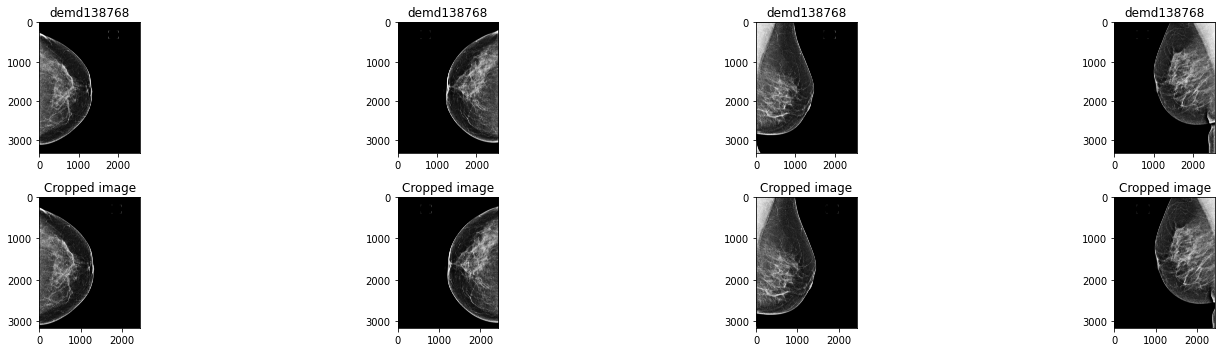

In [19]:
cropped_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(selected_paths), figsize = (22, 5))

for i in range(len(arr_uint8)):
    
    # Plot original
    ax[0][i].imshow(arr_uint8[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot cropped
    cropped_img = CropBorders(img=arr_uint8[i])
    cropped_img_list.append(cropped_img)
    ax[1][i].imshow(cropped_img, cmap="gray")
    ax[1][i].set_title("Cropped image")

    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/1_cropped.png", dpi=150)

---

## Removing artefacts using OpenCV `inpaint()`


- **Proposed method:**
    - Step 1: Get mask of artefacts
        - Step 1.1: Binarise (methods of binarising can vary)
        - Step 1.2: Removing noise from mask
        - Step 1.3: Remove the breast region from the mask
    - Step 2: Inpaint using the mask
        - Step 2.1: Invert mask
        - Step 2.2: inpaint

### Step 1 - Get mask of artifacts (a.k.a binarisation a.k.a thresholding)

#### Step 1.1 - Try to binarise using `cv2.theshold()` and `cv2.adaptiveThreshold()`

- **References:**
    - [Creating mask using thresholding](https://stackoverflow.com/questions/53592055/opencv-remove-text-from-image?noredirect=1&lq=1)
    - [`threshold` documentation](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)
    - [`adaptiveThreshold` documentation](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#ga72b913f352e4a1b1b397736707afcde3)
    - [Explanation of Otsu's thresholding](https://www.learnopencv.com/otsu-thresholding-with-opencv/)
    
- **Observations:**
    - `cv2.threshold()` and `cv2.adaptiveThreshold()` requires the input image to be `dtype=uint8`. This is not ideal, we lose granularity in the information when we convert from `float64` to `uint8`.

In [20]:
def Binarisation(img, maxval, show=False):
    
    # First convert image to uint8.
    ##img = skimage.img_as_ubyte(img)
    img = (255*(img/float(np.max(img)))).astype('uint8') 
    
    thresh, th1 = cv2.threshold(src=img,
                                thresh=0.1,
                                maxval=maxval,
                                type=cv2.THRESH_BINARY) # Global thresholding

    otsu_thresh, th2 = cv2.threshold(src=img,
                                     thresh=0,
                                     maxval=maxval,
                                     type=cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding

    th3 = cv2.adaptiveThreshold(src=img,
                                maxValue=maxval,
                                adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                                thresholdType=cv2.THRESH_BINARY,
                                blockSize=9,
                                C=-1)
    
    th4 = cv2.adaptiveThreshold(src=img,
                                maxValue=maxval,
                                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                thresholdType=cv2.THRESH_BINARY,
                                blockSize=9,
                                C=-1)

    images = [img, th1, th2, th3, th4]
    titles = ['Original Image',
              'Global Thresholding (v = 0.1)',
              'Global Thresholding (otsu)',
              'Adaptive Mean Thresholding',
              'Adaptive Gaussian Thresholding']

    
    # --- Plot the different thresholds ---
    if show:
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (22, 5))

        for i in range(5):
            ax[i].imshow(images[i], cmap="gray")
            ax[i].set_title(titles[i])
        plt.show()
    
    return th1, th2, th3, th4


def DilateMask(mask):
    
    # Dilate mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    
    return dilated_mask


def ApplyMask(img, dilated_mask):

    # Apply change
    result = img.copy()
    result[dilated_mask == 0] = 0 # We only keep areas that are white (255)
    
    return result

#### Step 1.1 - Try to binarise manually

- **Observations:**
    1. Pros:
        - My method seems to be more accurate and straightforward. Able to pick up both the breast and the various artefacts.
    2. Cons:
        - If there is a white border, the border will be part of the breast contour. Have to remove it at a later stage.

In [21]:
def OwnGlobalBinarise(img, thresh, maxval):
    
    '''
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.
        
        
    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    '''

    
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    
    
    return binarised_img

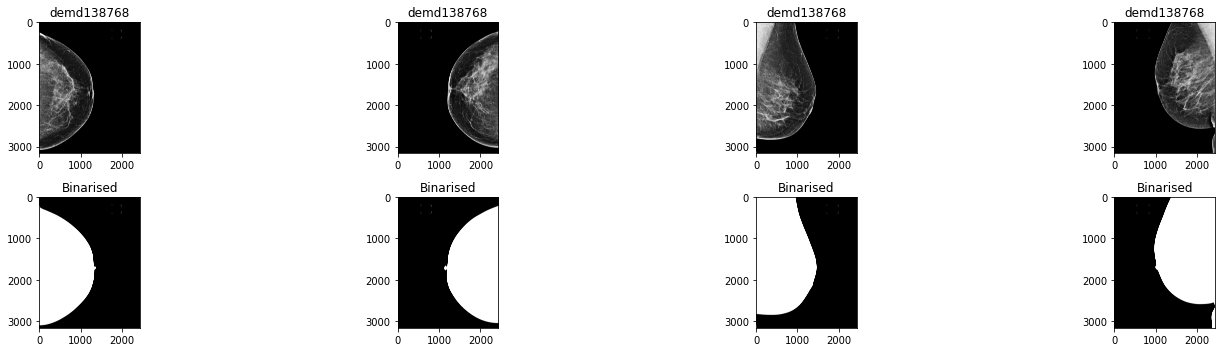

In [22]:
own_binarised_img_list = []

# Plot binarised images
fig, ax = plt.subplots(nrows=2, ncols=len(cropped_img_list), figsize=(22, 5))

for i in range(len(cropped_img_list)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot own binarised image.
    binarised_img = OwnGlobalBinarise(img=cropped_img_list[i], thresh=0.1, maxval=1.0)
    own_binarised_img_list.append(binarised_img)
    ax[1][i].imshow(binarised_img, cmap="gray")
    ax[1][i].set_title("Binarised")
    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/binarised.png", dpi=300)

#### Step 1.2 - Removing noise from mask

- **References:**
    - [Explanation of what is closing and opening of mask](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)
    - [Types of morphological operations](http://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm)
    - [Morph types documentation](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga7be549266bad7b2e6a04db49827f9f32)
    - [`getStructuringElement()` documentation](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gac342a1bb6eabf6f55c803b09268e36dc)

In [23]:
def OpenMask(mask, ksize=(23, 23), operation="open"):

    '''
    This function edits a given mask (binary image) by performing
    closing then opening morphological operations.
    
    Parameters
    ----------
    mask : {numpy.ndarray}
        The mask to edit.
        
    Returns
    -------
    edited_mask : {numpy.ndarray}
        The mask after performing close and open morphological
        operations. In the end we erode, to remove the edge of the breast.
    '''
        
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    
    # Then erode the edge of the breast

    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150,150))
    edited_mask = cv2.erode(edited_mask,kernel2,iterations = 2)
    edited_mask = cv2.GaussianBlur(edited_mask, (5, 5), cv2.BORDER_DEFAULT)


    return edited_mask

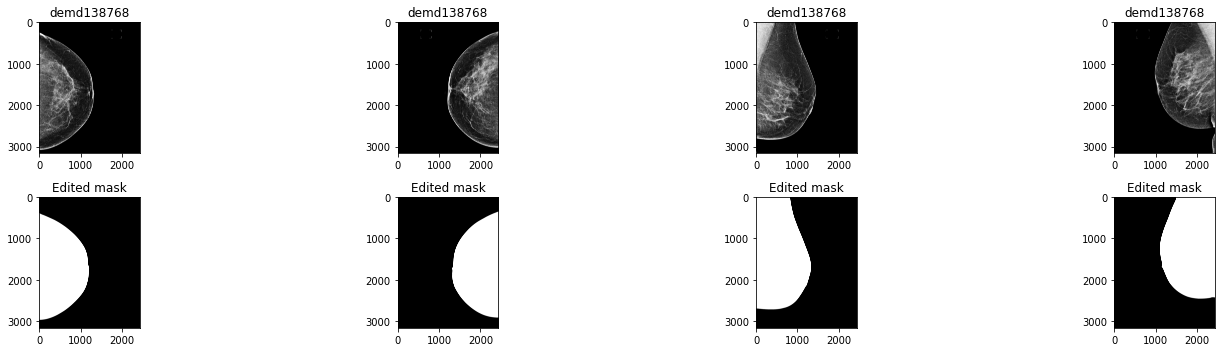

In [25]:


edited_mask_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(cropped_img_list), figsize=(22, 5))

for i in range(len(cropped_img_list)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(own_binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
    # Plot edited mask.
    edited_mask = OpenMask(mask=own_binarised_img_list[i], ksize=(33, 33), operation="open")
    edited_mask_list.append(edited_mask)
    ax[1][i].imshow(edited_mask, cmap="gray")
    ax[1][i].set_title("Edited mask")
    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/remove_noise.png", dpi=300)

#### Step 1.3 - Remove the breast region from the mask

- **References:**
    - https://stackoverflow.com/questions/49805514/extract-biggest-blob-with-opencv
    - [Contours tutorial](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
    - [`cv2.findContours` documentation](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)
    - [`cv2.drawContours` documentation](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc)
    - [`boundingRect` documentation](https://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#gacb413ddce8e48ff3ca61ed7cf626a366)
    - [`boundingRect` explanation with example](https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html)
    - [`contourArea` documentation](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1)
    - [Get top largest contours tutorial](https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/)
    - [`putText()` documentation](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576)

In [131]:
def SortContoursByArea(contours, reverse=True):
    
    '''
    This function takes in list of contours, sorts them based
    on contour area, computes the bounding rectangle for each
    contour, and outputs the sorted contours and their
    corresponding bounding rectangles.
    
    Parameters
    ----------
    contours : {list}
        The list of contours to sort.
        
    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    '''
    
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    
    return sorted_contours, bounding_boxes

In [132]:
def DrawContourID(img, bounding_box, contour_id):
    
    '''
    This function draws the given contour and its ID on the given
    image. The image with the drawn contour is returned.
    
    Parameters
    ----------
    img: {numpy.ndarray}
        The image to draw the contour on.
    bounding_box : {tuple of int}
        The bounding_rect of the given contour.
    contour_id : {int or float}
        The corresponding ID of the given `contour`.
        
    Returns
    -------
    img : {numpy.ndarray}
        The image after the `contour` and its ID is drawn on.
    '''
    
    # Center of bounding_rect.
    x, y, w, h = bounding_box
    center = ( ((x + w) // 2), ((y + h) // 2) )
    
    # Draw the countour number on the image
    cv2.putText(img=img,
                text=f"{contour_id}",
                org=center, # Bottom-left corner of the text string in the image.
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=10, 
                color=(255, 255, 255),
                thickness=40)

    return img

In [133]:
def XLargestBlobs(mask, top_X=None):
    
    '''
    This function finds contours in the given image and
    keeps only the top X largest ones.
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_X : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.
        
        
    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    '''
        
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(image=mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    
    n_contours = len(contours)
    
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:
        
        # Make sure that the number of contours to keep is at most equal 
        # to the number of contours present in the mask.
        if n_contours < top_X or top_X == None:
            top_X = n_contours
        
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = SortContoursByArea(contours=contours,
                                                             reverse=True)
        
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_X]
        
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)
        
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(image=to_draw_on, # Draw the contours on `to_draw_on`.
                                           contours=X_largest_contours, # List of contours to draw.
                                           contourIdx=-1, # Draw all contours in `contours`.
                                           color=1, # Draw the contours in white.
                                           thickness=-1) # Thickness of the contour lines.
        
    return n_contours, X_largest_blobs

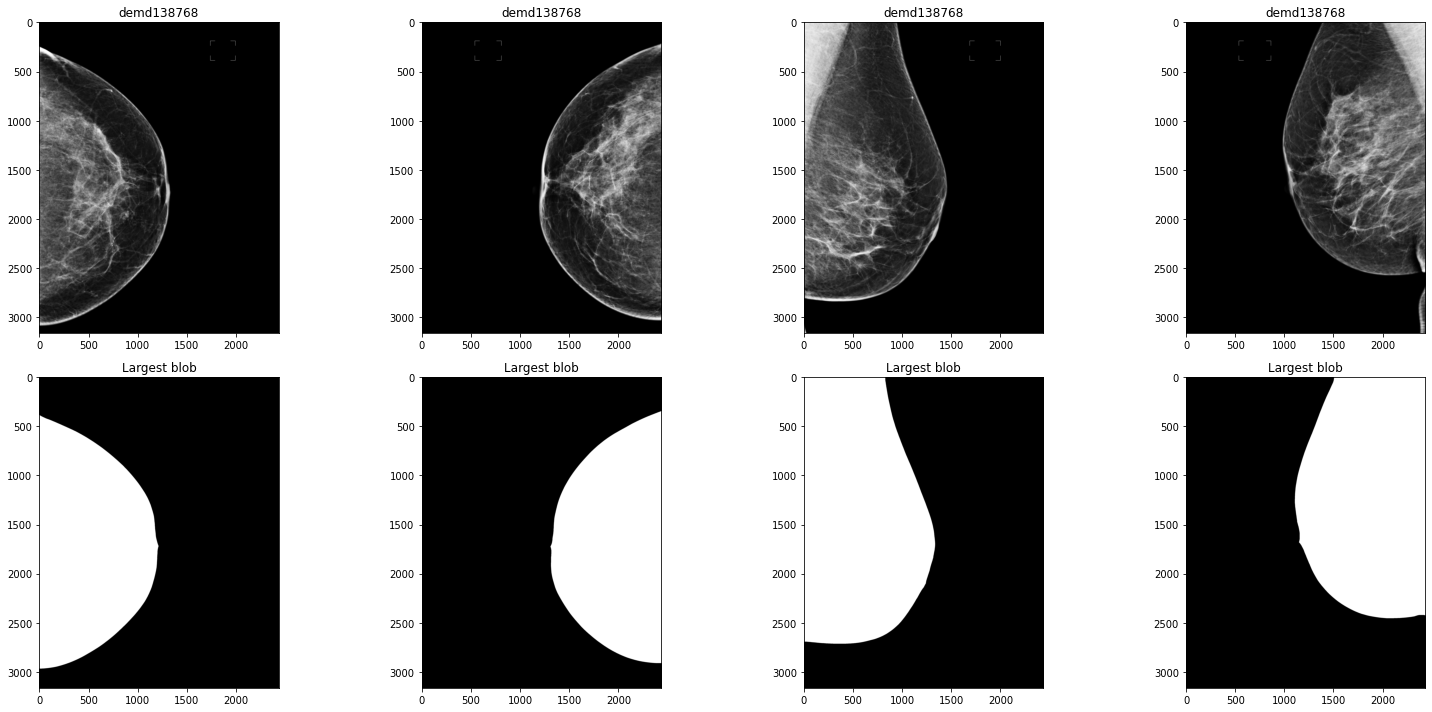

In [134]:
X_largest_blobs_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(cropped_img_list), figsize=(22, 10))

for i in range(len(cropped_img_list)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(own_binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
    # Plot largest-blob mask.
    _, X_largest_blobs = XLargestBlobs(mask=edited_mask_list[i], top_X=1)
    X_largest_blobs_list.append(X_largest_blobs)
    ax[1][i].imshow(X_largest_blobs, cmap="gray")
    ax[1][i].set_title("Largest blob")
    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/largest_blob.png", dpi=300)

### Step 2 - Use `X_largest_blob` as mask

In [135]:
def ApplyMask(img, mask):
    
    '''
    This function applies a mask to a given image. White
    areas of the mask are kept, while black areas are
    removed.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.
        
    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    '''

    
    masked_img = img.copy()
    masked_img[mask == 0] = 0
    
    return masked_img

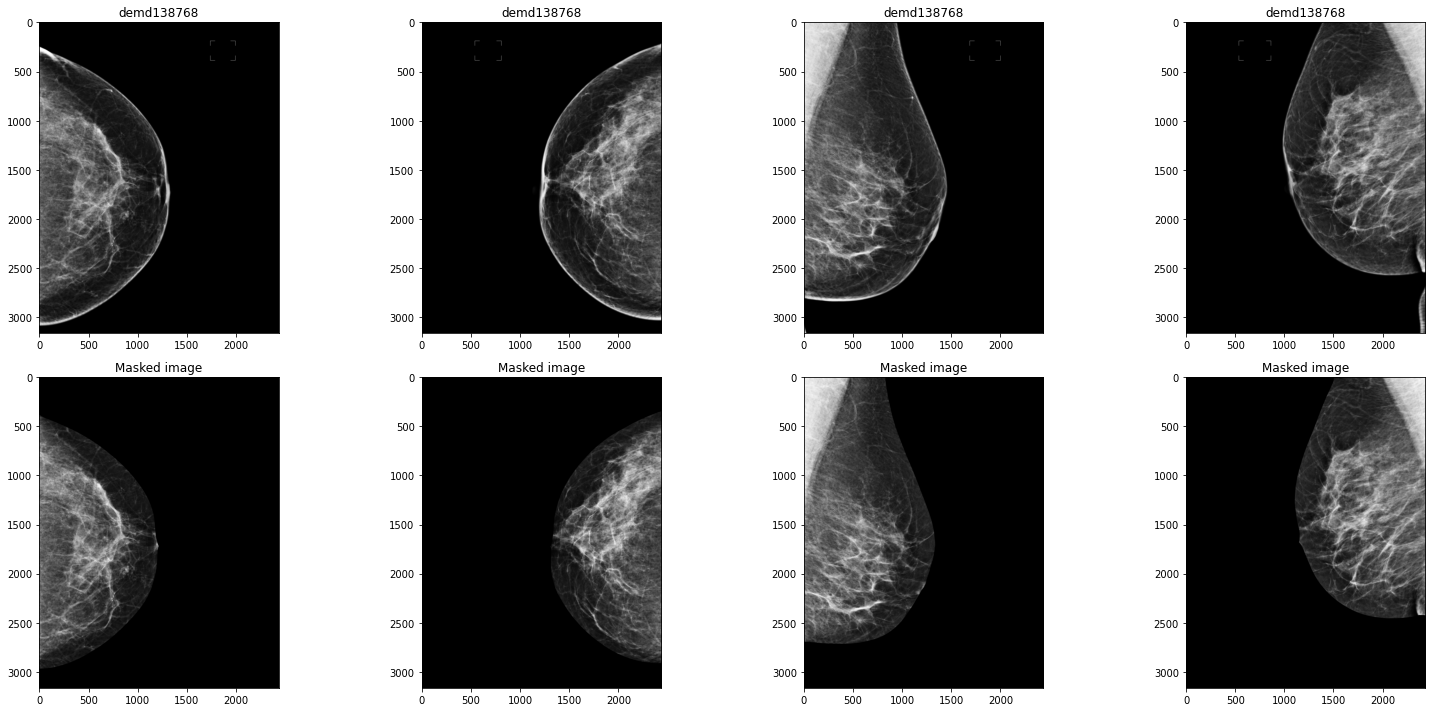

In [136]:
own_masked_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(cropped_img_list), figsize=(22, 10))

for i in range(len(cropped_img_list)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
    # Plot applying largest-blob mask
    masked_img = ApplyMask(img=cropped_img_list[i], mask=X_largest_blobs_list[i])
    own_masked_img_list.append(masked_img)
    ax[1][i].imshow(masked_img, cmap="gray")
    ax[1][i].set_title("Masked image")

    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/apply_mask.png", dpi=300)

# Resizing

In [137]:
def img_resize(img, shapeImgOut=(1024, 787), resizeMethod='span', resampleMethod='NEAREST', position='left'):
    # It resizes the input image to the size sizeImgOut with:
    # resizeMethod in {padding, span}
    # The padding option resizes the longest side of the pixel array and rescale the image 
    # maintaining the original ratio. 
    # Then creates a black square and pastes the rescaled image on it, 
    # on the left handside of the square (commented code to change this behaviour).
    # resampleMethod should be a method accepted by Image.resize:
    # (0) PIL.Image.NEAREST
    # (4) PIL.Image.BOX
    # (2) PIL.Image.BILINEAR
    # (5) PIL.Image.HAMMING
    # (3) PIL.Image.BICUBIC
    # (1) PIL.Image.LANCZOS
    # position can be 'centre' (padding on both sides) or 'left'(padding on right side)
    # returns (numpy array)

    if isinstance(shapeImgOut, int):
        # Per output quadrato:
        # shapeImgOut = (shapeImgOut, shapeImgOut)

        # the following keeps ratio if we set by default, 
        # shapeImgOut=1024 in the def.
        # But we have different ratios in optimam
        # we end up with images with same height and different width.
        # shapeImgOut = (shapeImgOut,ma.floor((img.shape[1]*shapeImgOut)/img.shape[0]))
        shapeImgOut = (shapeImgOut[0], shapeImgOut[1])

    sizeImgOut = shapeImgOut[::-1]

    if resizeMethod == 'padding':
        divMax = max(img.shape[0] / shapeImgOut[0], img.shape[1] / shapeImgOut[1])
        print(divMax)
        sizeResize = (int(img.shape[1] / divMax), int(img.shape[0] / divMax))
    else:
        sizeResize = sizeImgOut


    typeImgIn = img.dtype
    img = Image.fromarray(img.astype(np.uint8))
    img = img.resize(sizeResize, resample=getattr(Image, resampleMethod))

    if resizeMethod == 'padding':
        # PIL.Image.new(mode, size, color) creates a new image with the given mode and size  
        # L is (8-bit pixels, black and white)
        # Size is given as a (width, height)-tuple
        # default colour is 0
        out_img = Image.new('L', sizeImgOut)   
        # Image.paste(im, box=None, mask=None)
        
        if position == 'centre':
            out_img.paste(img, ((sizeImgOut[0] - img.size[0]) // 2, (sizeImgOut[1] - img.size[1]) // 2))
        else:
            out_img.paste(img, (0, 0))
    else:
        out_img = img

    return np.array(out_img).astype(typeImgIn)


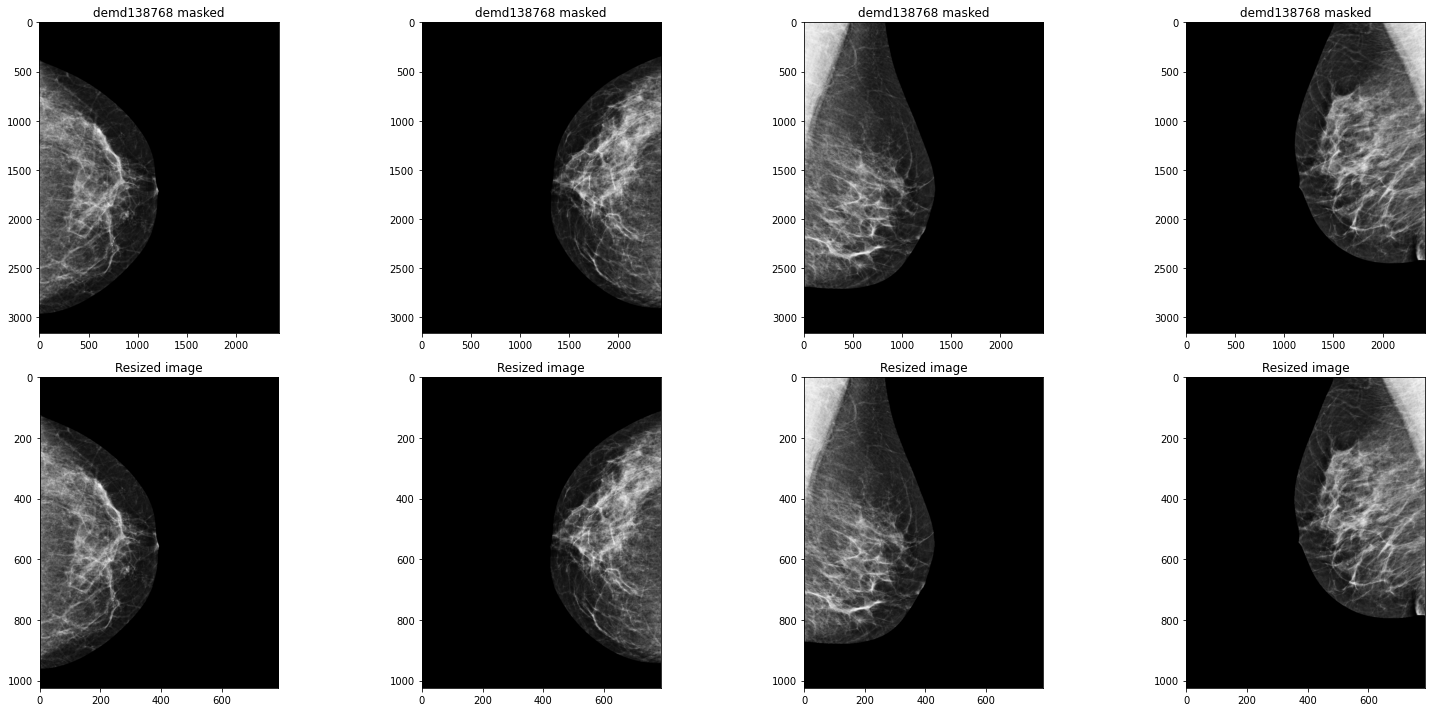

In [138]:
resized_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(cropped_img_list), figsize=(22, 10))

for i in range(len(cropped_img_list)):
    
    # Plot original image.
    ax[0][i].imshow(own_masked_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}" + ' masked')
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
    # Plot resized masked images
    resized_img = img_resize(img = own_masked_img_list[i], shapeImgOut=(1024,787), resizeMethod='span', resampleMethod='NEAREST', position='left')
    resized_img_list.append(resized_img)
    ax[1][i].imshow(resized_img, cmap="gray")
    ax[1][i].set_title("Resized image")

    
plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/resized.png", dpi=300)

---

## Contrast-Limited Adaptive Histogram Equalisation (CLAHE) 
We might not want to do it, as it changes each image individually?

In [43]:
def clahe(img, clip=2.0, tile=(8, 8)):
    
    '''
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to edit.
    clip : {int or floa}
        Threshold for contrast limiting.
    tile : {tuple (int, int)}
        Size of grid for histogram equalization. Input
        image will be divided into equally sized
        rectangular tiles. `tile` defines the number of
        tiles in row and column.
    
    Returns
    -------
    clahe_img : {numpy.ndarray}
        The edited image.
    '''
    
    # Convert to uint8.
    # img = skimage.img_as_ubyte(img)
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")

    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)

    return clahe_img

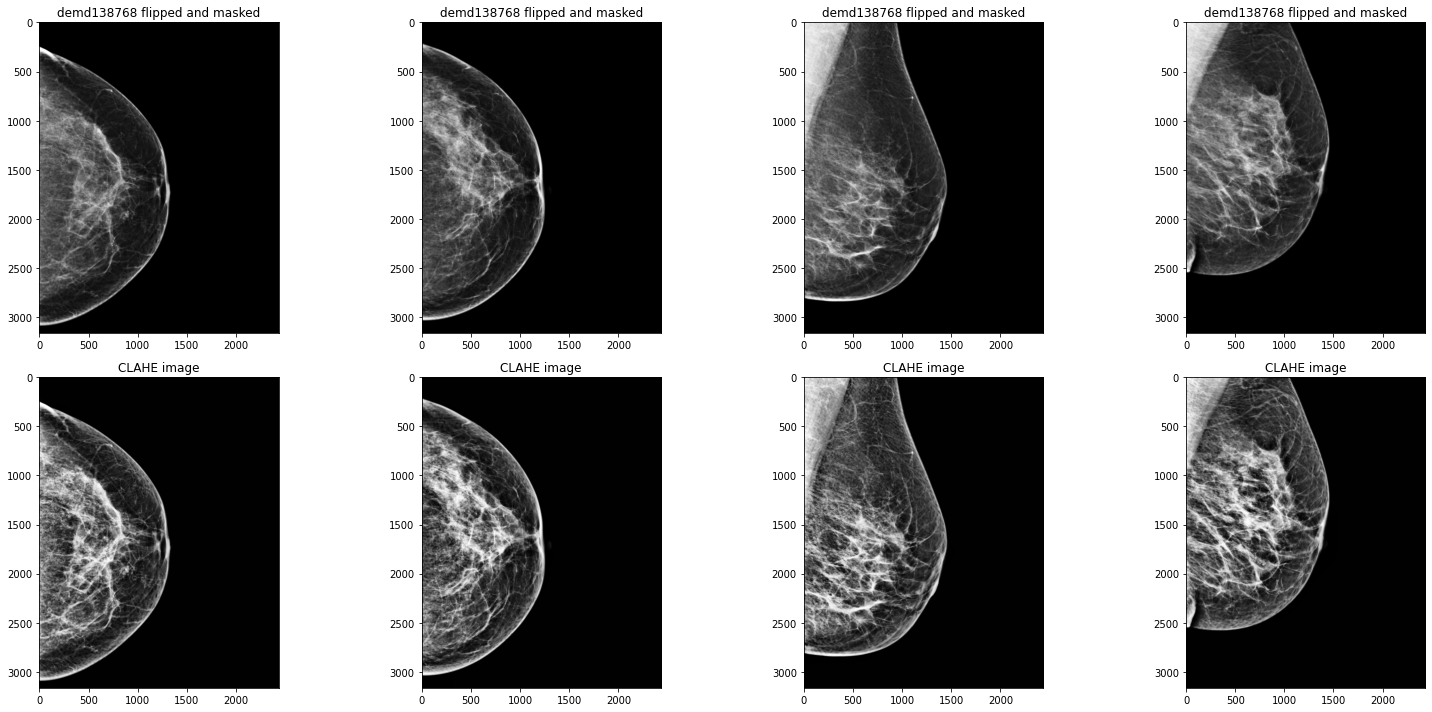

In [47]:
clahe_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(flipped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}"+ ' flipped and masked')
    
#     # Plot largest-blob mask.
#     ax[1][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[1][i].set_title("Largest blob")
    
#     # Plot final image.
#     ax[2][i].imshow(final_result_1_list[i], cmap="gray")
#     ax[2][i].set_title("FINAL RESULT")
    
    # CLAHE enhancement.
    clahe_img = clahe(img=flipped_img_list[i])
    clahe_img_list.append(clahe_img)
    
    ax[1][i].imshow(clahe_img_list[i], cmap="gray")
    ax[1][i].set_title("CLAHE image")

plt.tight_layout()
plt.savefig(fname="/home/celeste/Projects/TDA_breast_density/scripts/PreprocExamples/clahe.png", dpi=300)

---

# Removal of pectoral muscle


Trying to make this work, failing:
 https://github.com/gsunit/Pectoral-Muscle-Removal-From-Mammograms/blob/master/pectoral-segmentation.ipynb

## Ensuring same orientation of all images
In order for the algorithm to generalize over all mammograms, we first right-orient all images. To detect left-oriented breast images, we simply compare the number of nonzero pixels on both half of the images.

This is quite a rudimentary way to detect orientation, and works because the the background pixels are completely black and thus gives us an idea of the location of breast on either half of the image

In [139]:
from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

## Applying canny edge detection

In [140]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

## Applying Hough transform
Once we have obtained the edges using the Canny Edge Detector, we can apply Hough transform and make a list of output lines.

Each line is represented by an object with the following attributes

dist: perpendicular distance of the line from origin
angle: angle (in degrees) made by the perpendicular from the positive x-axis. This perpendicular is dropped on the line from the origin
point1, point2: two points on the line
Note: The x-axis and y-axis are oriented as shown in the image ouputs below.

In [154]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    #print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        #print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

## Shortlisting lines

We need to shortlist possible candidates for pectoral segmentation. A simple criteria for shortlisting can be simply checking whether the angle and dist values of each line lies inside a particular interval.

The intervals are MIN_ANGLE <= angle <= MAX_ANGLE and MIN_DIST <= dist <= MAX_DIST.

These 4 parameters can be easily learned given a bigger dataset of mammograms. However, for now these have been picked manually using judgement on the given 5 images, and seem to work well.

In [158]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]

        
    return shortlisted_lines


## Removing pectoral region
If more than one line is shortlisted, we select the one which will cause the least loss of information (the safest approach).

For this, we sort these lines by their distance from origin dist and pick the nearest line. Then we simply set the value to zero of those pixels enclosed within a polygon formed by the picked line and the border of the image.


In [165]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

## Displaying final result for removal


IndexError: list index out of range

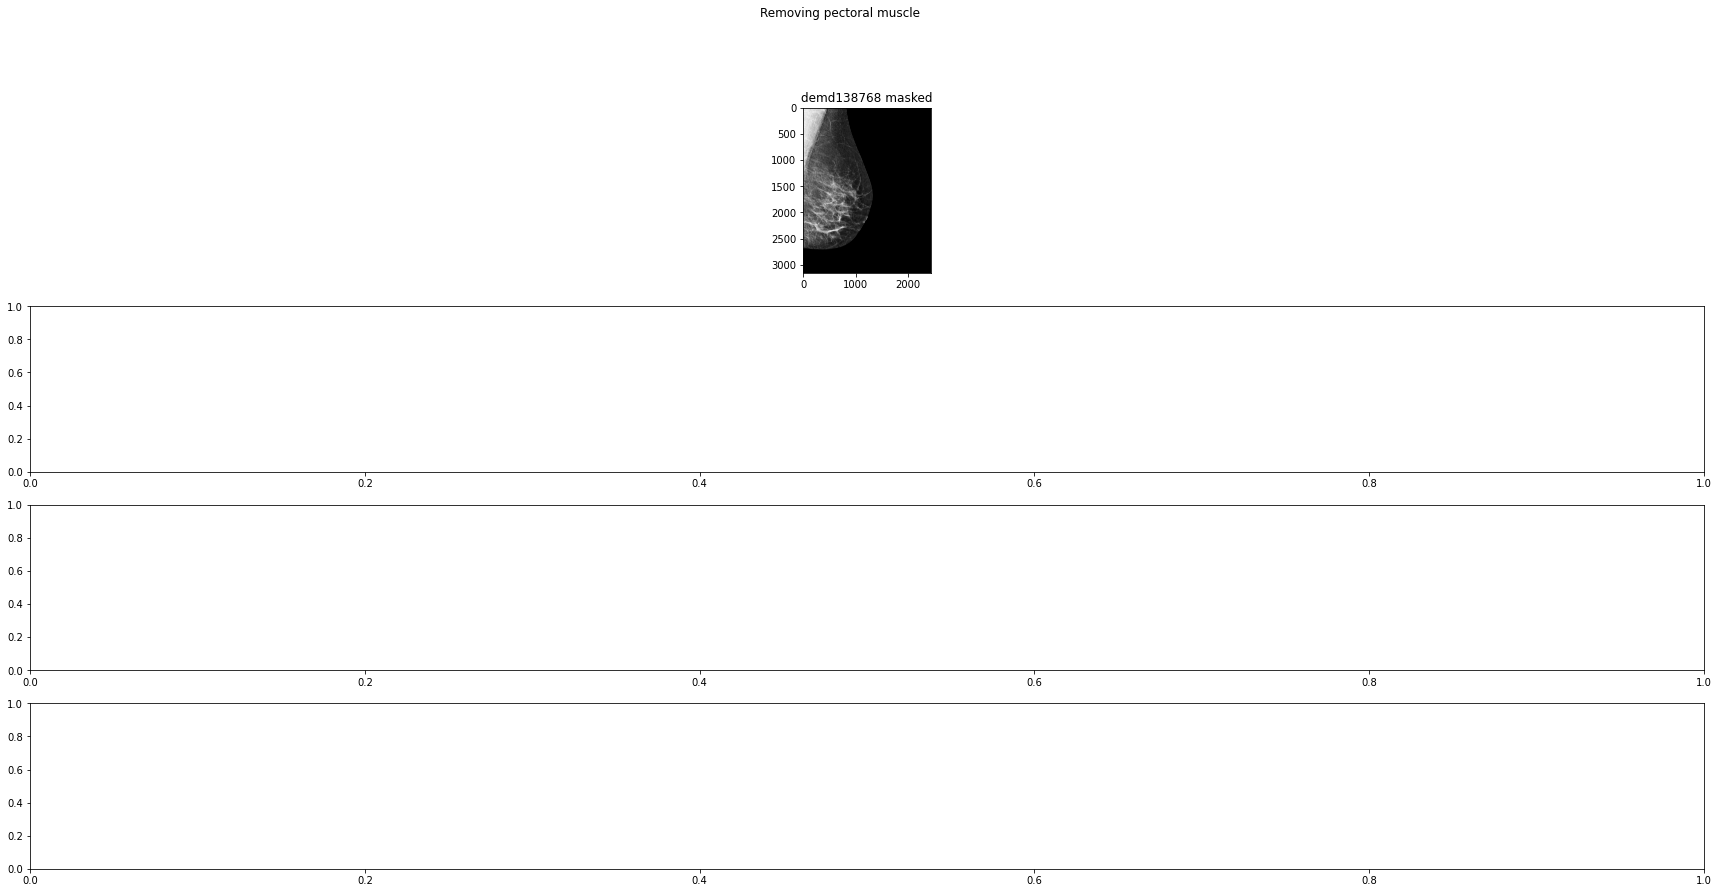

In [166]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (30, 14))
fig.suptitle("Removing pectoral muscle")


# Plot original image.
image = own_masked_img_list[2]
ax[0].imshow(image, cmap="gray")
ax[0].set_title(f"{ds[2].PatientID}" + ' masked')

# Plot canny image.
canny_img = apply_canny(image)

# Plot pec removed image.
lines = get_hough_lines(canny_img)
shortlisted_lines = shortlist_lines(lines)
rr, cc = remove_pectoral(shortlisted_lines)
image[rr, cc] = 0
ax[2].set_title('Pectoral muscle removed')
ax[2].imshow(image, cmap=pylab.cm.gray)
ax[2].axis('on') 

